# <font color='deepskyblue'>Cosmology MCMC notebook </font>

## <font color='deepskyblue'>Preliminaries</font>

In [1]:
# Install required packages (if not available on server)
# %pip install getdist

# Load a bunch of packages (honetsly I took this from someone else and just assumed it would be everything I would ever need so I put it here)
import numpy as np
import matplotlib.pyplot as plt
import pylab
import getdist, IPython
from numpy import random
from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples
import astropy
from astropy import units as u
import pandas as pd
import math 
import scipy.integrate as integrate
from astropy import cosmology
import scipy
import sympy
from sympy import Integral

## <span style='color:deepskyblue'> The $\Lambda$CDM Model </span>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model, this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\Omega_m + \Omega_\Lambda + \Omega_k = 1
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
H_0 \equiv h\,\frac{100 \text{km}}{\text{s Mpc}}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [2]:
H_0 = lambda h: h*100 # Hubble rate H_0(h) in km/s/Mpc
c = astropy.constants.c.value *1e-3 # Speed of light in km/s, I stole this from someone on the internet


Using $\Omega_k = 1-\Omega_\Lambda-\Omega_m $ and $a=(1+z)^{-1}$ we find:
\begin{equation}
H(z)=H_0(h)*\sqrt{\Omega_\Lambda+\left(1-\Omega_\Lambda-\Omega_m\right)\left(1+z\right)^2+\Omega_m\left(1+z\right)^3}
\end{equation}

In [3]:
PARSEC = 3.086 * 10**16 #m

def H(z, h, OmegaM, OmegaL): # Hubble rate H(z) in km/s/Mpc
    H = H_0(h) * math.sqrt(OmegaL + (1 - OmegaL - OmegaM) * (z+1)**2 + OmegaM * (z+1)**3)
    return H

def integrateH(z, h, OmegaM, OmegaL):
    res = integrate.quad(lambda x: H(x, h, OmegaM, OmegaL), 0, z)
    return res[0]

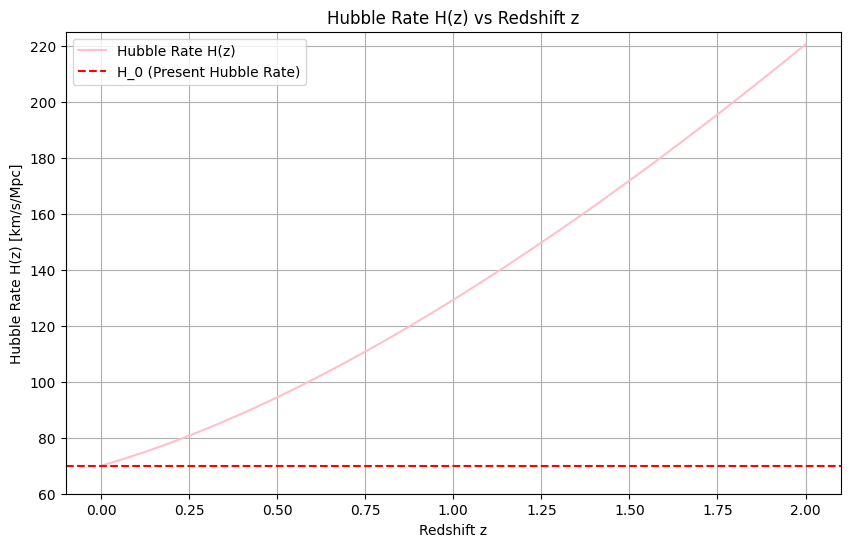

In [4]:
# Just assuming some values
h = 0.7
z = 0.2
OmegaM = 0.34 # Density parameter for non-relativistic matter
OmegaL = 0.65 # Density parameter for lambda

# Redshift range
z_values = np.linspace(0, 2, 100)  # Redshift from 0 to 3
H_values = [H(z, h, OmegaM, OmegaL) for z in z_values]  # Calculate H(z) for each z

# Plotting, helped by Duck.ai
plt.figure(figsize=(10, 6))
plt.plot(z_values, H_values, label='Hubble Rate H(z)', color='pink')
plt.title('Hubble Rate H(z) vs Redshift z')
plt.xlabel('Redshift z')
plt.ylabel('Hubble Rate H(z) [km/s/Mpc]')
plt.axhline(y=H_0(h), color='red', linestyle='--', label='H_0 (Present Hubble Rate)')
plt.legend()
plt.grid()
plt.ylim(60, 225)  # Adjust y-axis limits for better visibility
plt.show()

##  <span style='color:deepskyblue'>Supernovae Ia</span>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times 
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

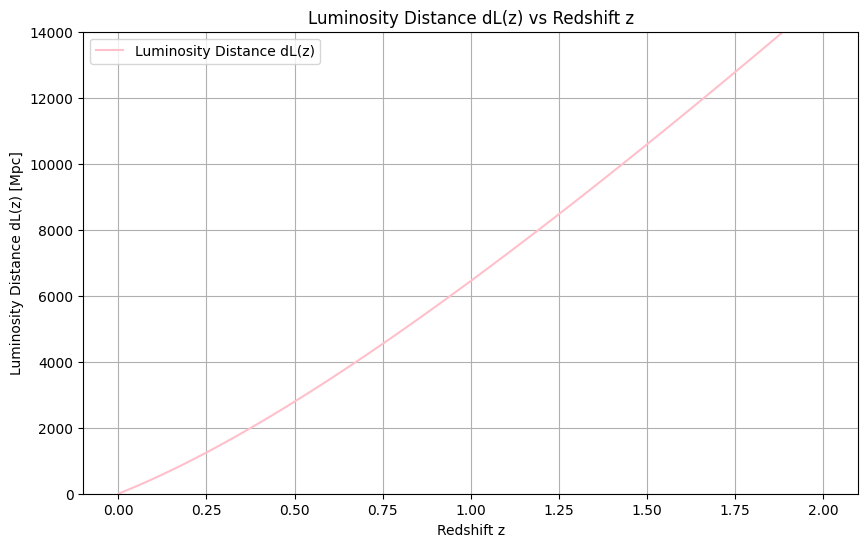

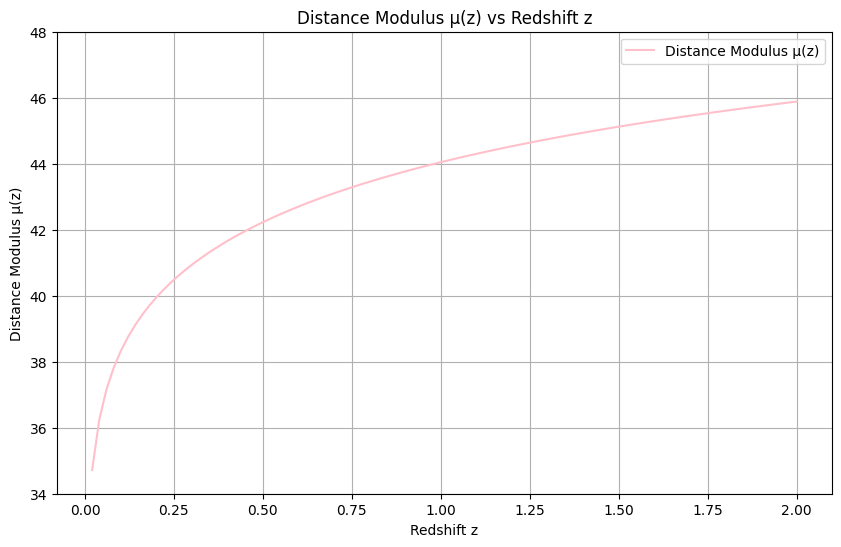

In [5]:
# c is already defined above

# Comoving distance
def Dz(z, h, OmegaM, OmegaL): 
    # using the integral of H(z) from 0 to z with the help of scipy.integrate.quad
    res = integrate.quad(lambda x: (H_0(h) / H(x, h, OmegaM, OmegaL)), 0, z)
    # the integral returns a tuple with the result and the error of which we only need the result
    return res[0]

# Luminosity distance
def dL(z,h,OmegaM,OmegaL): 
    # as mentioned above OmegaK = 1 - OmegaL - OmegaM
    OmegaK = 1 - OmegaL - OmegaM
    # using the comoving distance Dz(z) to calculate the luminosity distance
    d_z = Dz(z, h, OmegaM, OmegaL)
    # defining the cases where OmegaK is positive, zero or negative
    if OmegaK > 0:
        dl = 1 / math.sqrt(OmegaK) * math.sinh(math.sqrt(OmegaK) * d_z)
    elif OmegaK == 0:
        dl = d_z
    elif OmegaK < 0:
        dl = 1 / math.sqrt(-OmegaK) * math.sin(math.sqrt(-OmegaK) * d_z)
    # returning the luminosity distance in Mpc
    return c * (1+z) * dl / H_0(h) 

# I used ai for the plotting again

# Redshift range
z_values = np.linspace(0, 2, 100)  # Redshift from 0 to 3
dL_values = [dL(z, h, OmegaM, OmegaL) for z in z_values]  # Calculate dL(z) for each z

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(z_values, dL_values, label='Luminosity Distance dL(z)', color='pink')
plt.title('Luminosity Distance dL(z) vs Redshift z')
plt.xlabel('Redshift z')
plt.ylabel('Luminosity Distance dL(z) [Mpc]')
plt.grid()
plt.legend()
plt.ylim(0, 14000)  # Adjust y-axis limits for better visibility
plt.show()

# Theoretical distance modulus
def mu(z, h, OmegaM, OmegaL): 
    # using the luminosity distance dL(z) to calculate the distance modulus
    dl = dL(z, h, OmegaM, OmegaL) 
    if dl <= 0:
        return float('nan')  # Return NaN if luminosity distance is non-positive
    # returning the distance modulus, converting dl from Mpc to pc
    return 5 * math.log10(dl * 1e6 / 10)

# Redshift range
z_values = np.linspace(0, 2, 100)  # Redshift from 0 to 3
mu_values = [mu(z, h, OmegaM, OmegaL) for z in z_values]  # Calculate mu(z) for each z

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(z_values, mu_values, label='Distance Modulus μ(z)', color='pink')
plt.title('Distance Modulus μ(z) vs Redshift z')
plt.xlabel('Redshift z')
plt.ylabel('Distance Modulus μ(z)')
plt.grid()
plt.legend()
plt.ylim(34, 48)  # Adjust y-axis limits for better visibility
plt.show()

## <span style='color:deepskyblue'>The Union2.1 Compilation</span>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [6]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)
# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [7]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus = sigmas

In [8]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once
import scipy.integrate as integrate

# luminosity distance in pc
dpc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

In [9]:
# store the data in a pandas dataframe for easier manipulation
dataframe = pd.DataFrame({"redshift":zs, 
                   "distance_modulus":dist_mod,
                   "distance_modulus_error":err_dist_mod, 
                   "Luminosity distance pc":dpc,
                   "luminosity_distance_Mpc":dMpc ,
                   "error_luminosity_distance_Mpc":dMe})
dataframe.describe()

,redshift,distance_modulus,distance_modulus_error,Luminosity distance pc,luminosity_distance_Mpc,error_luminosity_distance_Mpc
count,580.000000,580.000000,580.000000,5.800000e+02,580.000000,580.000000
mean,0.361631,40.028495,0.222955,2.209307e+09,2209.306847,578.672983
std,0.327353,3.195595,0.126012,2.317339e+09,2317.338603,882.688022
min,0.015000,33.824609,0.084144,5.819984e+07,58.199838,8.415859
25%,0.054550,36.920249,0.151396,2.422198e+08,242.219796,33.323077
50%,0.294028,40.884198,0.189029,1.502674e+09,1502.674447,241.058999
75%,0.551700,42.517637,0.241556,3.188077e+09,3188.076719,796.924410
max,1.414000,45.410744,1.006812,1.208228e+10,12082.277932,7101.793911


In [10]:
# sorting the red shift values in ascending order for better visualization later on
dataframe.sort_values(by=['redshift'], inplace=True)

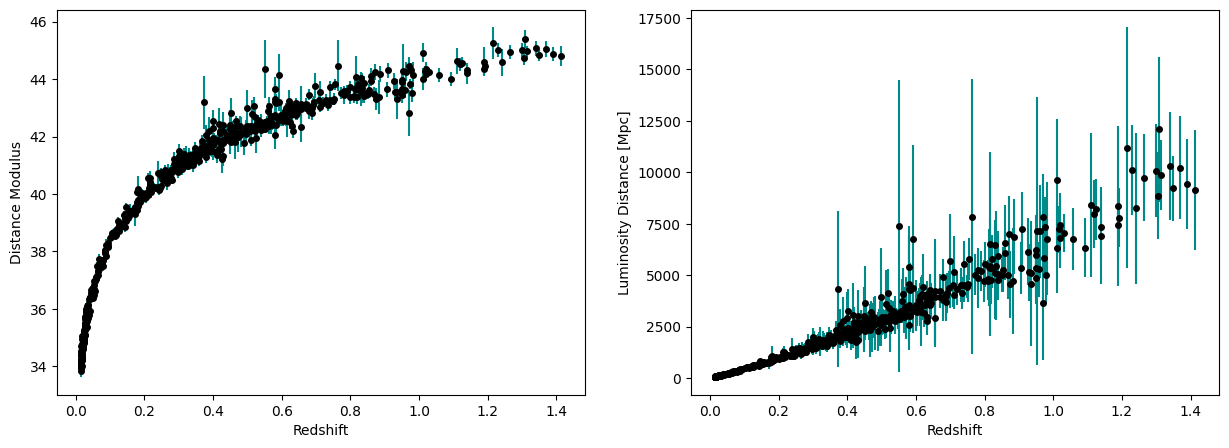

In [11]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(dataframe['redshift'], 
             dataframe['distance_modulus'], 
             yerr=dataframe["distance_modulus_error"], 
             fmt='o', 
             color='black', 
             ecolor='darkcyan', 
             markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(dataframe['redshift'], 
             dataframe['luminosity_distance_Mpc'], 
             yerr=dataframe['error_luminosity_distance_Mpc'], 
             fmt='o', 
             color='black', 
             ecolor='darkcyan', 
             markersize=4)
plt.show()

## <span style='color:deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</span>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <span style='color:deepskyblue'>Prior</span>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <span style='color:deepskyblue'>Likelihood</span>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <span style='color:deepskyblue'>Evidence</span>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <span style='color:deepskyblue'>Posterior</span>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <span style='color:deepskyblue'>Markov-Chain Monte Carlo</span>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$
    * If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

In [12]:
# We can vectorize the mu function to massively speed up the analysis
# This allows us to apply the mu function to an array of redshift values at once, 
# improving performance compared to looping through each value.
function = np.vectorize(mu)

# The way to speed up this function even further is to create a new function which already does the operations on 
# the redshifts and just takes the parameters as variables instead of repeating the operations on the redshifts
mu_vec = lambda h, OmegaM, OmegaL: function(dataframe['redshift'], h, OmegaM, OmegaL)

# defining the chi2 function
# This function calculates the chi-squared statistic, which measures the goodness of fit 
# between the model predictions (using mu_vec) and the observed distance modulus values.
def chi2(h, OmegaM, OmegaL):
    return np.sum(np.square(np.subtract(mu_vec(h, OmegaM, OmegaL), dataframe['distance_modulus'])) / (np.square(dataframe['distance_modulus_error'])))

# defining the function to generate the new parameters
# This function generates new parameters by sampling from normal distributions centered 
# around the current parameters, with specified standard deviations for each parameter.
def new_parameters(h, OmegaM, OmegaL):
    new_h = np.random.normal(h, 0.05)
    new_OmegaM = np.random.normal(OmegaM, 0.01)
    new_OmegaL = np.random.normal(OmegaL, 0.01)
    return np.array([new_h, new_OmegaM, new_OmegaL])

# defining the criteria on which to accept or reject the new parameters
# This function implements the Metropolis-Hastings algorithm to decide whether to accept 
# the proposed parameters based on their chi-squared values.
def accept_move(chi2current, chi2prop):
    # generating a random value between 0 and 1
    r = np.random.uniform(0, 1)
    # accept if the chi2 of the proposed parameters is lower than that of the current parameters
    # or if the chi2 of the proposed parameters is higher than that of the current parameters, 
    # but the random value is smaller than the exponential of the difference between the two chi2 values divided by 2
    if chi2prop < chi2current:
        return True
    elif r <= min(1, np.exp(-(chi2prop - chi2current) / 2)):
        return True
    # otherwise reject
    else:
        return False

# Initialize variables for the Markov Chain Monte Carlo (MCMC) process
# This includes lists for accepted and rejected chi-squared values, 
# a counter for the number of steps, and the initial parameter values.
accepted = []
rejected = []
chain = []
n = 0
N_steps = 580  # Initialize the number of steps
burn_in = 15   # add a burn in period of 15 steps
theta0 = np.array([0.5, 0.5, 0.5])  # Initialize the parameters

filename = "MC_Chain_SNIa.dat" 
# Initialize the chi2 for the current parameters
chi2current = chi2(*theta0)

# Open the file and write the header, while the loop is running we will write the accepted values in the file
# This allows us to save the results of the MCMC process for later analysis.
with open(filename, 'w') as f:
    f.write("h\tOmega_M\tOmega_L\tOmegaK\tchi2\t")
    
    # Main loop for the MCMC process
    # Propose new parameters, calculate chi-squared, and decide whether to accept or reject the new parameters.
    while n < N_steps:
        # Propose a new set of parameters by generating a random normal distribution around the current parameters 
        thetaprop = new_parameters(*theta0)
        # Initialize the chi2 for the proposed parameters
        chi2prop = chi2(*thetaprop)
        # Accept or reject the proposed parameters using the function accept_move
        if accept_move(chi2current, chi2prop):
            # if the move is accepted, we set the current parameters to the proposed parameters
            theta0 = thetaprop
            # and the current chi2 to the chi2 of the proposed parameters
            chi2current = chi2prop
            # and lastly we record the new parameters and chi2 value in the .dat file
            if n >= burn_in:    
                f.write(f"\n{theta0[0]}\t{theta0[1]}\t{theta0[2]}\t{1 - theta0[1] - theta0[2]}\t{chi2current}\t")
                chain.append(theta0)
            accepted.append
            # we increase the counter by 1 nonetheless 
        n += 1 


In [13]:
# load the data into a pandas dataframe
data = pd.read_csv("MC_Chain_SNIa.dat", sep="\t")
data

,h,Omega_M,Omega_L,OmegaK,chi2,Unnamed: 5
0,0.668755,0.489019,0.485699,0.025282,662.125923,NaN
1,0.669642,0.483137,0.475372,0.041491,659.918801,NaN
2,0.678409,0.475037,0.487479,0.037484,651.004624,NaN
3,0.678618,0.459509,0.480377,0.060114,645.636995,NaN
4,0.676099,0.456342,0.468039,0.075619,645.826407,NaN
5,0.669728,0.430012,0.475557,0.094431,643.071202,NaN
6,0.681722,0.425756,0.458816,0.115428,640.685648,NaN
7,0.669426,0.420484,0.472985,0.106531,641.889413,NaN
8,0.673142,0.411274,0.465584,0.123142,631.059372,NaN
9,0.675817,0.421430,0.474268,0.104301,629.792675,NaN


After completion of the programme, your MC chain will (*hopefully*) look something like this:

`#Omega_m  Omega_L  h`

`0.297     0.703    0.698`

`0.285     0.715    0.701`

`0.288     0.712    0.699`

`...`

## <span style='color:deepskyblue'>Plotting: GetDist</span>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

Removed no burn in
0.68  <  h  <  0.69  at  68% CL
0.39  <  OmegaM  <  0.45  at  68% CL
0.48  <  OmegaL  <  0.61  at  68% CL
-0.0  <  Omegak  <  0.08  at  68% CL





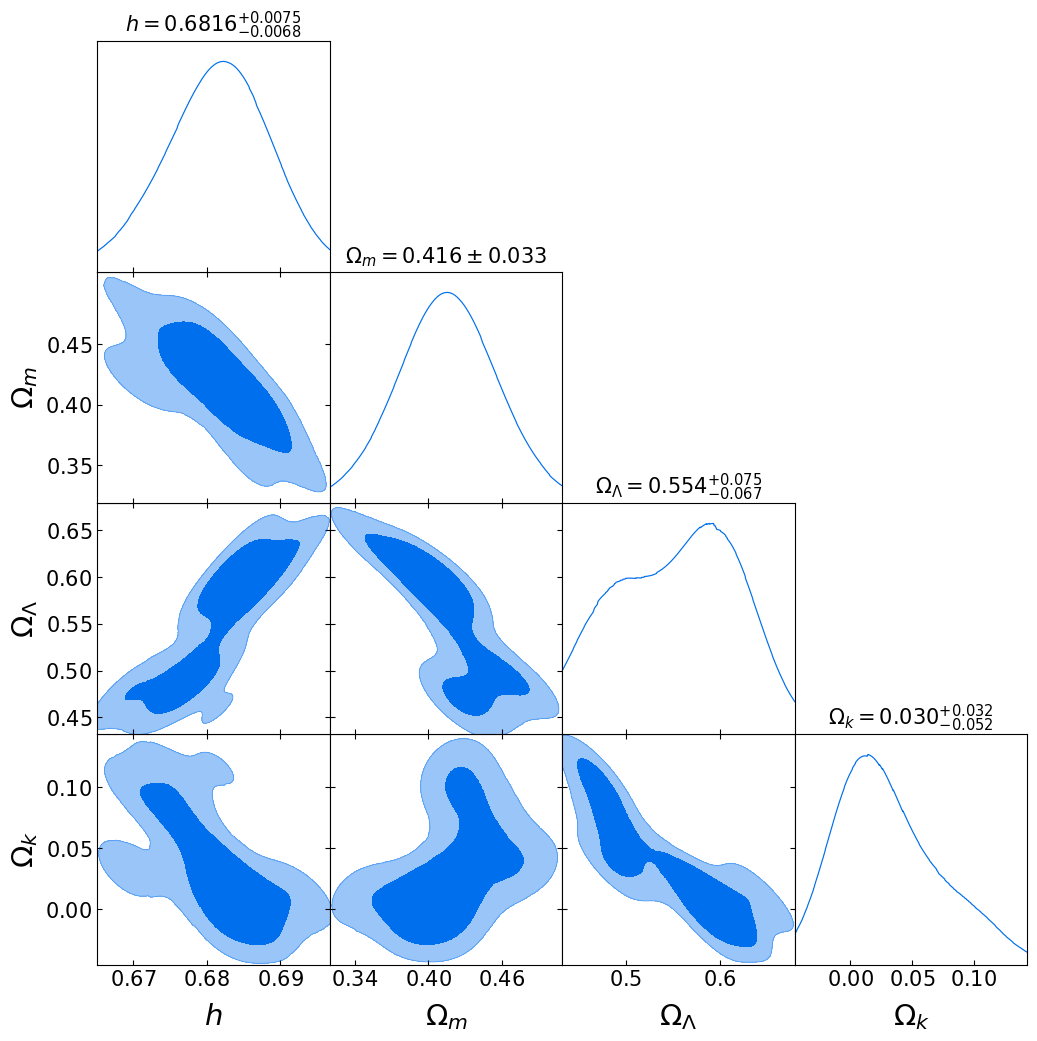

In [14]:
# These are just randomly generated values. YOU WILL HAVE TO USE THE RESULTS OF YOUR MCMC CHAIN!
h, OmegaM, OmegaL, Omegak = data["h"], data["Omega_M"], data["Omega_L"], data["OmegaK"]

# Here let's just define variable names, labels, and so on
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = 4 # The number of variables we're plotting

my_samples = np.array([h, OmegaM, OmegaL, Omegak]) # This creates a higher-dimensional array with all our data,
my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim)))) # and this reshapes it in a convenient form...
samples1 = MCSamples(samples = my_samples, labels = my_labels, names = my_names) # ... to create an "MCSamples" data type, which GetDist can use

conf_level = 0.6827 # The usual 1-sigma confidence level

# Let's print a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(samples1.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(samples1.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n\n")

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples1, filled = True, title_limit=1)

Here I will attempt to make a convergence test

In [15]:
class mcmc:
    def __init__(self):
        self.accepted = []
        self.c = []

        # Initialize the list of rejected chi2 values
        self.rejected = []

        # Initialize the number of steps
        self.N_steps = 580

        # Initialize the parameters
        self.burn_in = 15  
    
    def run_chain(self,i):
        n = 0

        # Initialize the parameters, using a uniform distribution and some prior knowledge about the parameters
        theta0 = np.random.uniform([0.5, 0.3, 0.5], [1, 0.4, 0.9])

        # Initialize the chi2 for the current parameters
        chi2current=chi2(*theta0)
        filename = f"MC_Chain_SNIa_{i}.dat"
        
        # Open the file and write the header, while the loop is running we will write the accepted values in the file
        # the file is automatically closed at the end. This is better coding practise than using f.close() at the end. 
        with open(filename, 'w') as f:
            f.write("h\tOmega_M\tOmega_L\tOmegaK\tchi2\t")
            while n < self.N_steps:
                # Propose a new set of parameters by generating a random normal distribution around the current parameters 
                thetaprop = new_parameters(*theta0)
                # Initialize the chi2 for the proposed parameters
                chi2prop = chi2(*thetaprop)
                # Accept or reject the proposed parameters using the function accept_move
                if accept_move(chi2current,chi2prop):
                    # if the move is accepted, we set the current parameters to the proposed parameters
                    theta0 = thetaprop
                    # and the current chi2 to the chi2 of the proposed parameters
                    chi2current = chi2prop
                    # and lastly we record the new parameters and chi2 value in the .dat file
                    if n >= self.burn_in: 
                        f.write(f"\n{thetaprop[0]}\t{thetaprop[1]}\t{thetaprop[2]}\t{1-thetaprop[1]-thetaprop[2]}\t{chi2prop}\t")
                        self.accepted.append(chi2prop)
                    self.c.append(theta0)
                else:
                    self.rejected.append(chi2prop)
                # we increase the counter by 1 nonetheless 
                n += 1 

In [16]:
class mcmc_convergence_test(mcmc):
    # We inherit the mcmc class
    def __init__(self, Nchains):

        # We call the __init__ function of the mcmc class
        super().__init__()
        self.Nchains = Nchains
        self.chains = [mcmc() for i in range(self.Nchains)]
        self.data = {}

    def run_convergence_test(self):

        # Initialize the chains
        for chain in self.chains:
            print("Running chain", self.chains.index(chain)+1, "of", self.Nchains)
            
            # Run the chains
            chain.run_chain(self.chains.index(chain)+1)

        # Calculate the within-chain variances
        # We use ddof=1 to calculate the sample variance instead of the population variance
        # This is because we are calculating the variance of a sample of the population
        W = np.mean([np.var(chain.accepted, ddof=1) for chain in self.chains])

        # Calculate the between-chain variances
        # We use axis=0 to calculate the mean of each column
        # This is because we want to calculate the mean of each parameter
        # theta_bar is a 2D array with shape (Nchains, Nparameters) where Nchains is the number of chains and Nparameters is the number of parameters
        # theta_bar[i,j] is the mean of the jth parameter for the ith chain
        theta_bar = np.mean([chain.accepted for chain in self.chains], axis=0)
        # B is the between-chain variance, which is the sum of the squared differences between the mean of each parameter and the mean of all parameters
        B = self.N_steps / (self.Nchains - 1) * np.sum(np.square(theta_bar - np.mean(theta_bar, axis=0)), axis=0)

        # Calculate the estimated variances
        # N is the total number of steps taken
        N = sum([len(chain.accepted) for chain in self.chains])
        # V_hat is the weighted average of W and B
        V_hat = (N-1)/N * W + B/N

        # Calculate the potential scale reduction factor, which is the square root of V_hat divided by W
        R_hat = np.sqrt(V_hat/W)

        # store the results
        self.data["Number of chains"]=self.Nchains
        self.data["Within-chain variance (W)"]=W
        self.data["Between-chain variance (B)"]=B
        self.data["Estimated variance (V_hat)"]=V_hat
        self.data["Potential scale reduction factor (R_hat)"]=R_hat

        # Check for convergence
        if R_hat < 1.1:
            print("The chains have converged.")
        else:
            print("The chains have not yet converged.")
    def plot(self):
        for chains in self.chains:
            plt.plot(chains.accepted, label=f"Chain {self.chains.index(chains)+1}")

        plt.legend()

    

In [17]:
# determine the mean of each parameter for each chain after convergence and store them in a dictionary
params = {"h":[], "Omega_M":[], "Omega_L":[], "OmegaK":[]}

for i in range(20):

    # loop over the 20 chains
    with open(f"MC_Chain_SNIa_{i+1}.dat", 'r') as f:

        # read the data from the .dat file
        data = pd.read_csv(f, sep="\t")
        
        # calculate the mean of each parameter and append it to the corresponding list in the dictionary
        params["h"] += [np.mean(data['h'])]
        params["Omega_M"]+= [np.mean(data['Omega_M'])]
        params["Omega_L"]+= [np.mean(data['Omega_L'])]
        params["OmegaK"]+= [np.mean(data['OmegaK'])]

In [18]:
SPEED_OF_LIGHT = 299792.458 # in km/s

# Function for calculating the luminosity distance
def tlm(z, h, OmegaM, OmegaL, OmegaK):
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaL +OmegaK *(1+x)**2), 0., z)[0]

# Function for calculating the distance modulus
def mu1(z, h, OmegaM, OmegaL, OmegaK):
    return 5. * (-1. + np.log10(tlm(z, h, OmegaM, OmegaL, OmegaK)))


d_min: [44.29613291229482, 44.29613291229482, 44.29613291229482, 44.30008212717799, 44.31070148835837, 44.32026448640614, 44.32517480320478, 44.32517480320478, 44.339554105874804, 44.359003906504824, 44.43767683173425, 44.43767683173425, 44.47843457747127, 44.481259746131876, 44.48457016060032, 44.49853580698549, 44.51302920464802, 44.535577375471995, 44.537282223408724, 44.569557023787816, 44.59294736005336, 44.59984018211259, 44.60912435222191, 44.60912435222191, 44.64749969293078, 44.68783159152231, 44.73437215621692, 44.78005417083309, 44.803433689290785, 44.83804843418384, 44.83804843418384, 44.84536370441651, 44.872132762040444, 44.883266971028974, 44.96863432535035, 44.982118894252785, 45.01408278000798, 45.02463632849598, 45.04559469096273, 45.0560004429153, 45.08692947142479, 45.11672839279931, 45.12751213610001, 45.135541428813035, 45.14752998770865, 45.14752998770865, 45.177224125091115, 45.22585334385327, 45.22585334385327, 45.23268971749023, 45.23545342331015, 45.255290435

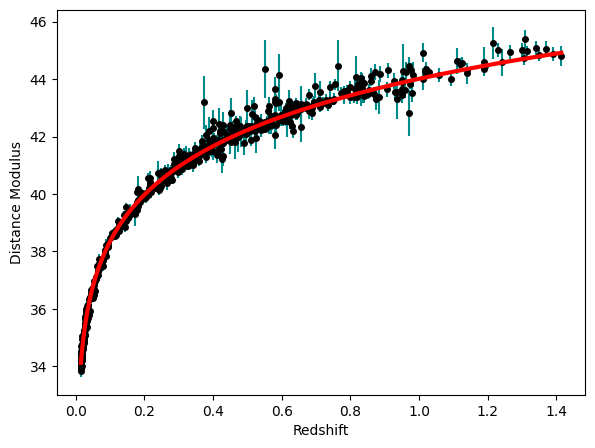

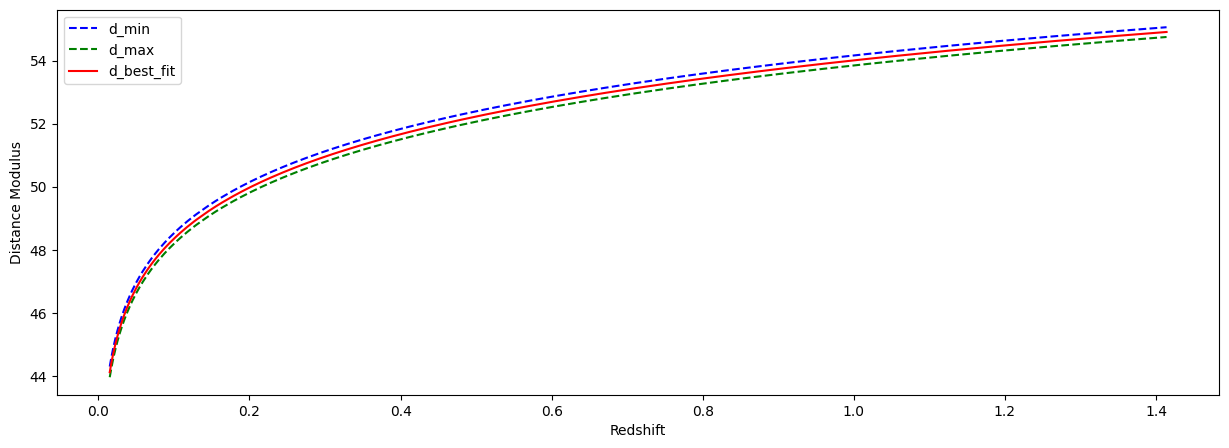

In [19]:
# Create a figure for the plots
plt.figure(figsize=(15, 5))

# Sort the redshift values
zsort = sorted(zs)

# Get best fit parameters
best_fit_params = samples1.getMeans()
h_best, OmegaM_best, OmegaL_best, OmegaK_best = best_fit_params

# Calculate distance modulus for best fit parameters
d_best_fit = [mu1(z, h_best, OmegaM_best, OmegaL_best, OmegaK_best) for z in zsort]

# Calculate the min and max values for the parameters
percentiles = np.percentile(samples1.samples, [16, 84], axis=0)
h_min, h_max = percentiles[0, 0], percentiles[1, 0]
OmegaM_min, OmegaM_max = percentiles[0, 1], percentiles[1, 1]
OmegaL_min, OmegaL_max = percentiles[0, 2], percentiles[1, 2]
OmegaK_min, OmegaK_max = percentiles[0, 3], percentiles[1, 3]

# Calculate distance modulus for min and max parameters
d_min = [mu1(z, h_min, OmegaM_min, OmegaL_min, OmegaK_min) for z in zsort]
d_max = [mu1(z, h_max, OmegaM_max, OmegaL_max, OmegaK_max) for z in zsort]

# Print to check values
print("d_min:", d_min)
print("d_max:", d_max)
print("d_best_fit:", d_best_fit)
print("Length of zsort:", len(zsort))
print("Length of d_min:", len(d_min))
print("Length of d_max:", len(d_max))

# Calculate the best fit values
best_fit_h = samples1.mean('h')
best_fit_OmegaM = samples1.mean('OmegaM')
best_fit_OmegaL = samples1.mean('OmegaL')

# Generate the best fit distance modulus values
best_fit_values = mu_vec(best_fit_h, best_fit_OmegaM, best_fit_OmegaL)

# Print the best fit values
print("Best fit distance modulus values:")
for z, d in zip(dataframe['redshift'], best_fit_values):
    print(f"Redshift: {z}, Distance Modulus: {d}")

# Plot distance modulus calculated using the new parameters versus redshift
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(dataframe['redshift'], 
             dataframe['distance_modulus'], 
             yerr=dataframe["distance_modulus_error"], 
             fmt='o', 
             color='black', 
             ecolor='darkcyan', 
             markersize=4)

# Now plot the best fit line
plt.plot(zsort,
         best_fit_values,  
         color='red', 
         label='Best fit',
         lw=3,
         zorder=10)

# Create another figure to analyze d_min, d_max, and d_best_fit -> basically this is my error bars but clearer
plt.figure(figsize=(15, 5))
plt.plot(zsort, d_min, label='d_min', color='blue', linestyle='--')
plt.plot(zsort, d_max, label='d_max', color='green', linestyle='--')
plt.plot(zsort, d_best_fit, label='d_best_fit', color='red', linestyle='-')
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.legend()
plt.show()


As the graphs show, the best fine line shows that the parameters are good and the error is minimal (although increasing with redshift, this hared to tell from the graph it is recommended to look at the printed values).